# EDA: House Prices

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
# Load data
# Убедитесь, что пути к файлам верные
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')

In [4]:
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)

# Display first 5 rows of the training data
train_df.head()

# Get information about the columns and non-null values
train_df.info()

Train shape:  (1460, 81)
Test shape:  (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Ove

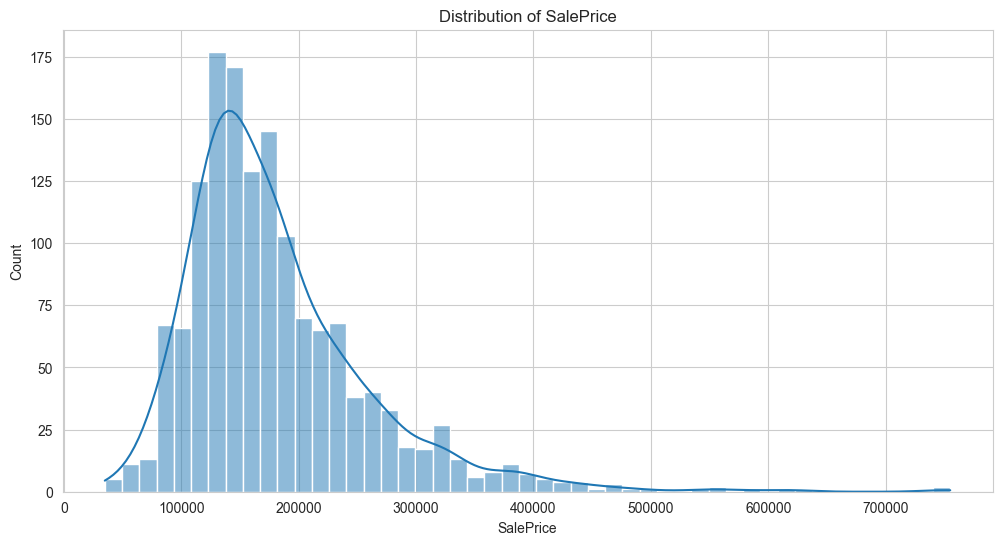

In [5]:
plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Distribution of SalePrice')
plt.show()

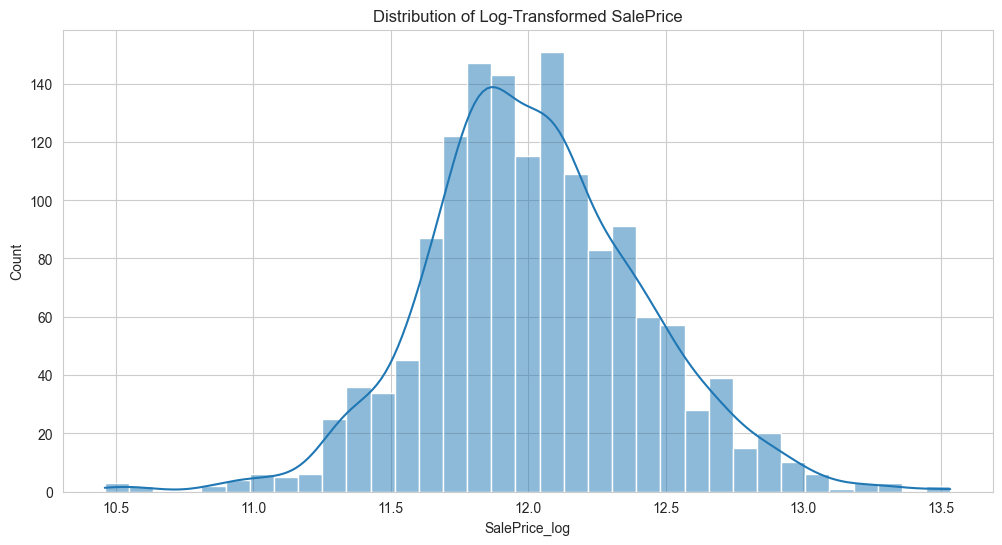

In [6]:
# Apply log transformation to SalePrice
train_df['SalePrice_log'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(12, 6))
sns.histplot(train_df['SalePrice_log'], kde=True)
plt.title('Distribution of Log-Transformed SalePrice')
plt.show()

In [7]:
# Combine train and test data for easier processing, excluding SalePrice
all_data = pd.concat((train_df.loc[:,'MSSubClass':'SaleCondition'],
                      test_df.loc[:,'MSSubClass':'SaleCondition']))

# Features where NaN means "None" (no feature)
# For these categorical features, we fill NaN with the string 'None'
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'):
    all_data[col] = all_data[col].fillna('None')

# For these numerical features, NaN means 0 (e.g., no garage -> 0 garage area)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    all_data[col] = all_data[col].fillna(0)

# After filling, let's check which columns still have missing values
remaining_missing = all_data.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
print("Remaining missing values:")
print(remaining_missing)

Remaining missing values:
MSZoning         4
LotFrontage    486
Utilities        2
Exterior1st      1
Exterior2nd      1
Electrical       1
KitchenQual      1
Functional       2
SaleType         1
dtype: int64


In [8]:
# Group by neighborhood and fill missing LotFrontage with the median of the neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

# For the remaining categorical features, fill with the mode (most common value)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Check if there are any missing values left
print("Total missing values left:", all_data.isnull().sum().sum())

Total missing values left: 0


In [9]:
# Convert some numerical variables that are really categories into strings
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Create new features by combining existing ones
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = all_data['FullBath'] + 0.5 * all_data['HalfBath'] + all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath']
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
# A simple binary feature indicating if the house has a pool or not
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a 2nd floor
all_data['Has2ndFlr'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a garage
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a basement
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
# A simple binary feature indicating if the house has a fireplace
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Log-transform skewed numerical features
from scipy.stats import skew

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

print("Applied log transformation to", len(skewed_feats), "skewed features.")

Applied log transformation to 27 skewed features.


In [10]:
# Apply one-hot encoding to the categorical features
all_data = pd.get_dummies(all_data)

# Separate the data back into training and testing sets
X = all_data[:train_df.shape[0]]
X_test = all_data[train_df.shape[0]:]

# The target variable (we already log-transformed it)
y = train_df['SalePrice_log']

# Let's check the shapes of our final datasets
print("Shape of X (training features):", X.shape)
print("Shape of y (training target):", y.shape)
print("Shape of X_test (test features):", X_test.shape)

Shape of X (training features): (1460, 348)
Shape of y (training target): (1460,)
Shape of X_test (test features): (1459, 348)


In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
import time

# Set up k-fold cross-validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# Define a function to calculate cross-validation scores with timing
def get_rmse(model, model_name):
    print(f"--> Starting cross-validation for {model_name}...")
    start_time = time.time()
    score = -cross_val_score(model, X.values, y.values, cv=kfolds, scoring='neg_root_mean_squared_error').mean()
    end_time = time.time()
    print(f"--> Finished {model_name}. Took {end_time - start_time:.2f} seconds.")
    return score

# --- Model Definitions ---
ridge = Ridge(alpha=15)
lasso = Lasso(alpha=0.0004, max_iter=5000)
elasticnet = ElasticNet(alpha=0.0005, l1_ratio=0.9)
xgb = XGBRegressor(learning_rate=0.05, n_estimators=3460,
                   max_depth=3, min_child_weight=0,
                   gamma=0, subsample=0.7,
                   colsample_bytree=0.7,
                   reg_alpha=0.005,
                   nthread=-1,
                   scale_pos_weight=1, seed=27,
                   random_state=42)

# --- Model Evaluation ---
models = {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': elasticnet, 'XGBoost': xgb}
scores = {}

print("Calculating cross-validation scores for each model...")

for name, model in models.items():
    scores[name] = get_rmse(model, name)
    print(f"    {name} RMSE: {scores[name]:.5f}\n")

print("--- All scores ---")
for name, score in scores.items():
    print(f"{name}: {score:.5f}")


Calculating cross-validation scores for each model...
Ridge RMSE: 0.12725
